In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import scipy.signal as sp
import matplotlib.patches as mtp
import scipy.stats as ss
import scipy.stats.distributions as dist

import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate

In [2]:
dir_data='./Data/'
time_freq='7'

atl = xr.open_dataset(dir_data+'sst_NorthAtlantic'+time_freq+'D.nc')
atl.sst

<xarray.DataArray 'sst' (time: 2052, lat: 240, lon: 360)>
[177292800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1981-09-02 1981-09-09 ... 2020-12-23
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * lon      (lon) float32 270.1 270.4 270.6 270.9 ... 359.1 359.4 359.6 359.9
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

In [3]:
def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]

    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')

    # 
    xarr_inter = out.copy()
    xarr_inter.name += '_intercept'
    xarr_inter.attrs['units'] = ''
    xarr_inter.values = intercept.reshape(xarr.shape[1:])
    
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])

    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])

    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    xarr_out['intercept'] = xarr_inter
        

    return xarr_out

In [4]:
def spectrum1(h, dt):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h, axis=0)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

def spectrum2(h, dt, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weight = np.ones(nsmooth, dtype=float) / nsmooth
    weights = np.ones((nsmooth, 1, 1), dtype=float) / nsmooth
    freqs_s = sp.fftconvolve(freqs, weight, mode='valid')
    
    ps_s = sp.fftconvolve(ps, weights, mode='valid')
    psd_s = sp.fftconvolve(psd, weights, mode='valid')
    
    return freqs_s, ps_s, psd_s
    
def spectrum2p(h, dt, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s
        

def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    winp = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    win = np.expand_dims(np.expand_dims(winp, 1), 1)
    return win

def spectrum4(h, dt, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    #h_detrended = detrend(h)
    
    winweights = quadwin(n)
    #h_win = h_detrended * winweights
    h_win = h * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [5]:
atl_trend = xarray_trend(atl.sst)

In [6]:
atl_np_Time = atl.sst.time.to_pandas().index.to_julian_date().values
atl_np_Slope = atl_trend.slope.values
atl_np_Inter = atl_trend.intercept.values
atl_np_Trend = atl_np_Slope[...,None] * atl_np_Time + atl_np_Inter[:,:,None]
atl_np_Trend = np.swapaxes(np.swapaxes(atl_np_Trend,0,2),1,2)

atl_dt = atl.sst - atl_np_Trend

/var/folders/tj/cj2twzcd30jbzn574lsp6phw0000gn/T/ipykernel_46694/3731902643.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


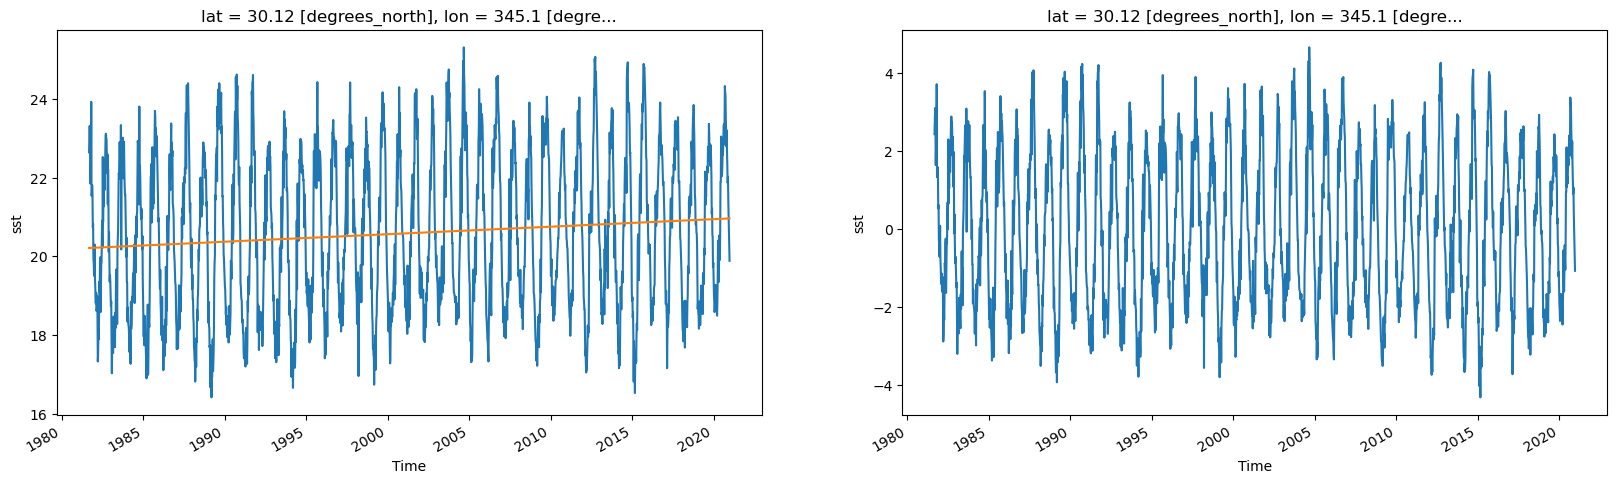

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
plt.subplot(1, 2, 1)
atl.sst.sel(lat=30, lon=345, method='nearest').plot()
(atl.sst.sel(lat=30, lon=345, method='nearest') - atl_dt.sel(lat=30, lon=345, method='nearest')).plot()

plt.subplot(1, 2, 2)
atl_dt.sel(lat=30, lon=345, method='nearest').plot()

In [8]:
def rm(x):
    return x - x.mean(dim='time')

atl_dt_month = atl_dt.groupby('time.month').apply(rm)

In [9]:
#Se calcula aquí el espectro de todos los datos sin tendencia aunque se use más tarde porque si no se satura la ram del colab.

freqs_t, ps_t, psd_t = spectrum1(atl_dt, dt=7)

In [10]:
promedio = np.array([])
for id in range(1,13):
   promedio=np.append(promedio, atl_dt.sel(lat=30, lon=345, method='nearest')[atl_dt.sel(lat=30, lon=345, method='nearest').time.dt.month==id].mean())

climm =atl_dt.sel(lat=30, lon=345, method='nearest').groupby('time.month').mean(dim='time')

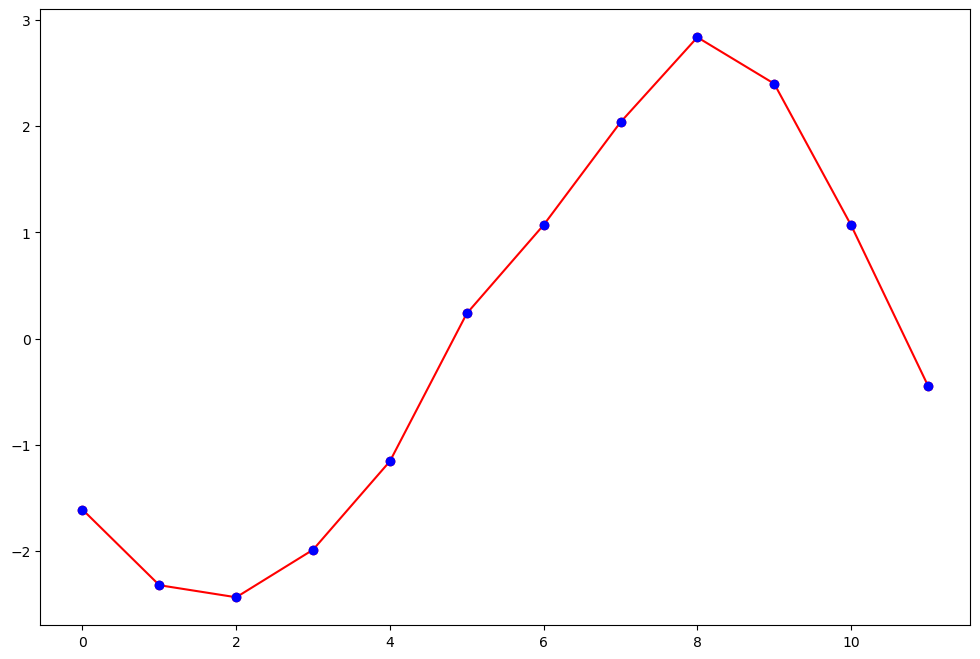

In [11]:
fig , ax = plt.subplots(figsize=(12,8))
ax.plot(promedio,'-ro')
ax.plot(climm,'bo')

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


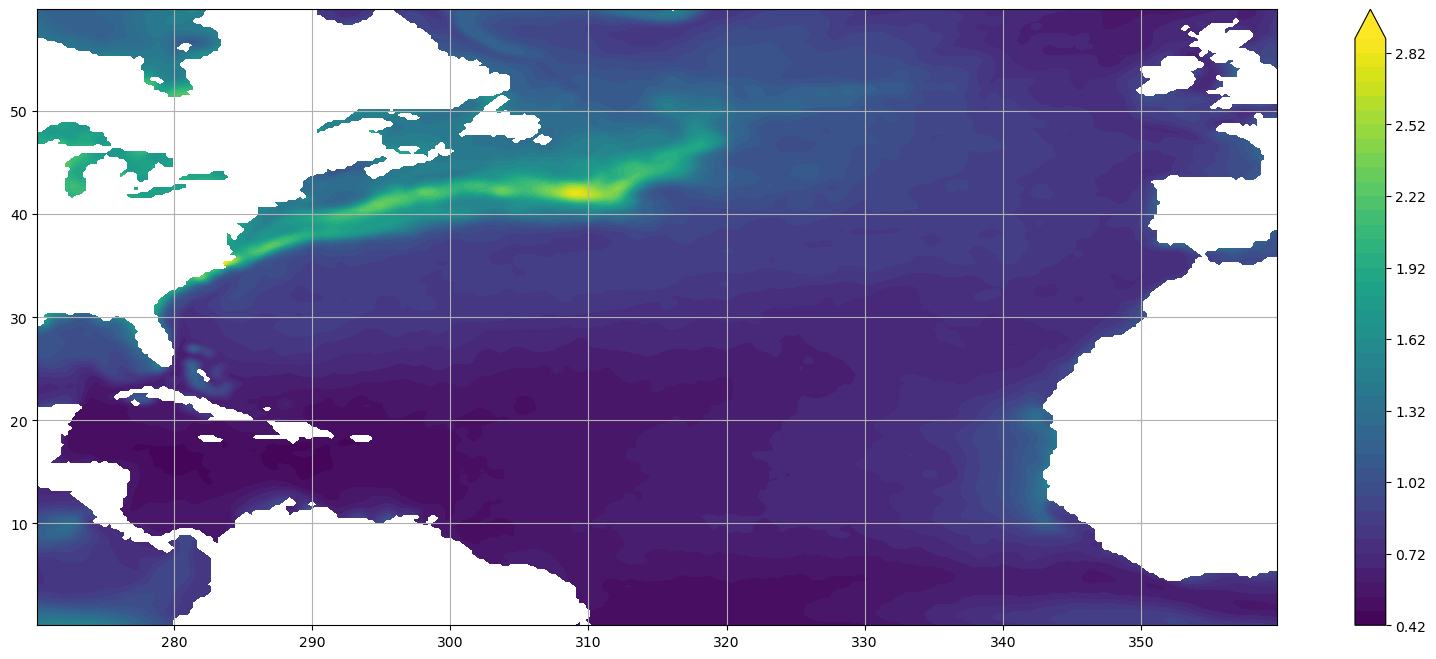

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
#levels = np.linspace(0, 0.2, 41)
A = ax.contourf(atl_dt_month.lon, atl_dt_month.lat, atl_dt_month.std(dim='time'), levels=40,
                 extend='max')
fig.colorbar(A)

#ax.contourf(atl_dt_month.lon, atl_dt_month.lat, atl_dt_month.std(dim='time'), levels=[0.0599, 0.06], colors='red')

ax.xaxis.grid(True, zorder=0)
ax.yaxis.grid(True, zorder=0)

In [13]:
ad_lat = atl_dt_month.lat.loc[10.5:26.5]
ad_lon = atl_dt_month.lon.loc[318:331]
ad = atl_dt_month.sel(lat=ad_lat, lon=ad_lon)
adp = atl_dt.sel(lat=ad_lat, lon=ad_lon)

In [14]:
a1_lat = atl_dt_month.lat.loc[32:37]
a1_lon = atl_dt_month.lon.loc[325:335]
a1 = atl_dt_month.sel(lat=a1_lat, lon=a1_lon)
a1p = atl_dt.sel(lat=a1_lat, lon=a1_lon)

a2_lat = atl_dt_month.lat.loc[32:37]
a2_lon = atl_dt_month.lon.loc[335:345]
a2 = atl_dt_month.sel(lat=a2_lat, lon=a2_lon)
a2p = atl_dt.sel(lat=a2_lat, lon=a2_lon)

a3_lat = atl_dt_month.lat.loc[32:37]
a3_lon = atl_dt_month.lon.loc[345:352]
a3 = atl_dt_month.sel(lat=a3_lat, lon=a3_lon)
a3p = atl_dt.sel(lat=a3_lat, lon=a3_lon)

a4_lat = atl_dt_month.lat.loc[24:29]
a4_lon = atl_dt_month.lon.loc[340:347]
a4 = atl_dt_month.sel(lat=a4_lat, lon=a4_lon)
a4p = atl_dt.sel(lat=a4_lat, lon=a4_lon)

a5_lat = atl_dt_month.lat.loc[28:35]
a5_lon = atl_dt_month.lon.loc[280:286]
a5 = atl_dt_month.sel(lat=a5_lat, lon=a5_lon)
a5p = atl_dt.sel(lat=a5_lat, lon=a5_lon)

a6_lat = atl_dt_month.lat.loc[30:40]
a6_lon = atl_dt_month.lon.loc[286:295]
a6 = atl_dt_month.sel(lat=a6_lat, lon=a6_lon)
a6p = atl_dt.sel(lat=a6_lat, lon=a6_lon)

a7_lat = atl_dt_month.lat.loc[33:43]
a7_lon = atl_dt_month.lon.loc[295:313]
a7 = atl_dt_month.sel(lat=a7_lat, lon=a7_lon)
a7p = atl_dt.sel(lat=a7_lat, lon=a7_lon)

a8_lat = atl_dt_month.lat.loc[33:52]
a8_lon = atl_dt_month.lon.loc[313:325]
a8 = atl_dt_month.sel(lat=a8_lat, lon=a8_lon)
a8p = atl_dt.sel(lat=a8_lat, lon=a8_lon)

a9_lat = atl_dt_month.lat.loc[5:12]
a9_lon = atl_dt_month.lon.loc[300:315]
a9 = atl_dt_month.sel(lat=a9_lat, lon=a9_lon)
a9p = atl_dt.sel(lat=a9_lat, lon=a9_lon)

a10_lat = atl_dt_month.lat.loc[4:9]
a10_lon = atl_dt_month.lon.loc[315:333]
a10 = atl_dt_month.sel(lat=a10_lat, lon=a10_lon)
a10p = atl_dt.sel(lat=a10_lat, lon=a10_lon)

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


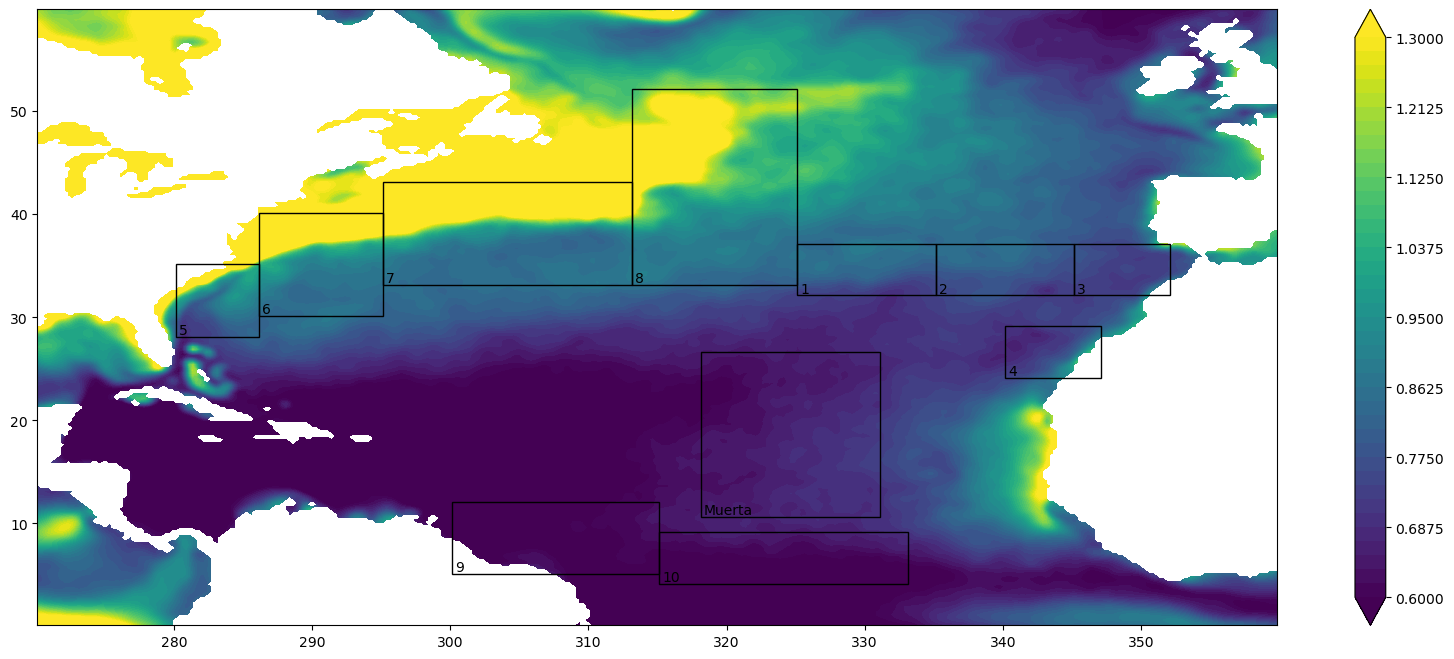

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0.6, 1.3, 41)
A = ax.contourf(atl_dt_month.lon, atl_dt_month.lat, atl_dt_month.std(dim='time'), 
                levels=levels, extend='both')
fig.colorbar(A)

#ax.contourf(atl_dt_month.lon, atl_dt_month.lat, atl_dt_month.std(dim='time'), levels=[0.0599, 0.06], colors='red')

ax.add_patch(mtp.Rectangle((a1_lon[0],a1_lat[0]), len(a1_lon)*0.25, len(a1_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a1_lon[1],a1_lat[1], '1')
ax.add_patch(mtp.Rectangle((a2_lon[0],a2_lat[0]), len(a2_lon)*0.25, len(a2_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a2_lon[1],a2_lat[1], '2')
ax.add_patch(mtp.Rectangle((a3_lon[0],a3_lat[0]), len(a3_lon)*0.25, len(a3_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a3_lon[1],a3_lat[1], '3')
ax.add_patch(mtp.Rectangle((a4_lon[0],a4_lat[0]), len(a4_lon)*0.25, len(a4_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a4_lon[1],a4_lat[1], '4')
ax.add_patch(mtp.Rectangle((a5_lon[0],a5_lat[0]), len(a5_lon)*0.25, len(a5_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a5_lon[1],a5_lat[1], '5')
ax.add_patch(mtp.Rectangle((a6_lon[0],a6_lat[0]), len(a6_lon)*0.25, len(a6_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a6_lon[1],a6_lat[1], '6')
ax.add_patch(mtp.Rectangle((a7_lon[0],a7_lat[0]), len(a7_lon)*0.25, len(a7_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a7_lon[1],a7_lat[1], '7')
ax.add_patch(mtp.Rectangle((a8_lon[0],a8_lat[0]), len(a8_lon)*0.25, len(a8_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a8_lon[1],a8_lat[1], '8')
ax.add_patch(mtp.Rectangle((a9_lon[0],a9_lat[0]), len(a9_lon)*0.25, len(a9_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a9_lon[1],a9_lat[1], '9')
ax.add_patch(mtp.Rectangle((a10_lon[0],a10_lat[0]), len(a10_lon)*0.25, len(a10_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a10_lon[1],a10_lat[1], '10')
ax.add_patch(mtp.Rectangle((ad_lon[0],ad_lat[0]), len(ad_lon)*0.25, len(ad_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(ad_lon[1],ad_lat[1], 'Muerta')

plt.show()

In [16]:
freqs1, ps1, psd1 = spectrum4(a1.values, dt=int(time_freq))
freqs2, ps2, psd2 = spectrum4(a2.values, dt=int(time_freq))
freqs3, ps3, psd3 = spectrum4(a3.values, dt=int(time_freq))
freqs4, ps4, psd4 = spectrum4(a4.values, dt=int(time_freq))
freqs5, ps5, psd5 = spectrum4(a5.values, dt=int(time_freq))
freqs6, ps6, psd6 = spectrum4(a6.values, dt=int(time_freq))
freqs7, ps7, psd7 = spectrum4(a7.values, dt=int(time_freq))
freqs8, ps8, psd8 = spectrum4(a8.values, dt=int(time_freq))
freqs9, ps9, psd9 = spectrum4(a9.values, dt=int(time_freq))
freqs10, ps10, psd10 = spectrum4(a10.values, dt=int(time_freq))

In [17]:
freqsd, psd, psdd = spectrum4(ad.values, dt=int(time_freq))
mediad = np.mean(np.mean(psdd, axis=1), axis=1)
freqsdp, psdp, psddp = spectrum4(adp.values, dt=int(time_freq))
mediadp = np.mean(np.mean(psddp, axis=1), axis=1)

In [18]:
media1 = np.mean(np.mean(psd1, axis=1), axis=1)
media2 = np.mean(np.mean(psd2, axis=1), axis=1)
media3 = np.nanmean(np.nanmean(psd3, axis=1), axis=1)
media4 = np.nanmean(np.nanmean(psd4, axis=1), axis=1)
media5 = np.nanmean(np.nanmean(psd5, axis=1), axis=1)
media6 = np.mean(np.mean(psd6, axis=1), axis=1)
media7 = np.mean(np.mean(psd7, axis=1), axis=1)
media8 = np.mean(np.mean(psd8, axis=1), axis=1)
media9 = np.nanmean(np.nanmean(psd9, axis=1), axis=1)
media10 = np.mean(np.mean(psd10, axis=1), axis=1)

In [19]:
#Sin quitar ciclo estacional.

freqs1p, ps1p, psd1p = spectrum4(a1p.values, dt=7)
freqs2p, ps2p, psd2p = spectrum4(a2p.values, dt=7)
freqs3p, ps3p, psd3p = spectrum4(a3p.values, dt=7)
freqs4p, ps4p, psd4p = spectrum4(a4p.values, dt=7)
freqs5p, ps5p, psd5p = spectrum4(a5p.values, dt=7)
freqs6p, ps6p, psd6p = spectrum4(a6p.values, dt=7)
freqs7p, ps7p, psd7p = spectrum4(a7p.values, dt=7)
freqs8p, ps8p, psd8p = spectrum4(a8p.values, dt=7)
freqs9p, ps9p, psd9p = spectrum4(a9p.values, dt=7)
freqs10p, ps10p, psd10p = spectrum4(a10p.values, dt=7)

In [20]:
media1p = np.mean(np.mean(psd1p, axis=1), axis=1)
media2p = np.mean(np.mean(psd2p, axis=1), axis=1)
media3p = np.nanmean(np.nanmean(psd3p, axis=1), axis=1)
media4p = np.nanmean(np.nanmean(psd4p, axis=1), axis=1)
media5p = np.nanmean(np.nanmean(psd5p, axis=1), axis=1)
media6p = np.mean(np.mean(psd6p, axis=1), axis=1)
media7p = np.mean(np.mean(psd7p, axis=1), axis=1)
media8p = np.mean(np.mean(psd8p, axis=1), axis=1)
media9p = np.nanmean(np.nanmean(psd9p, axis=1), axis=1)
media10p = np.mean(np.mean(psd10p, axis=1), axis=1)

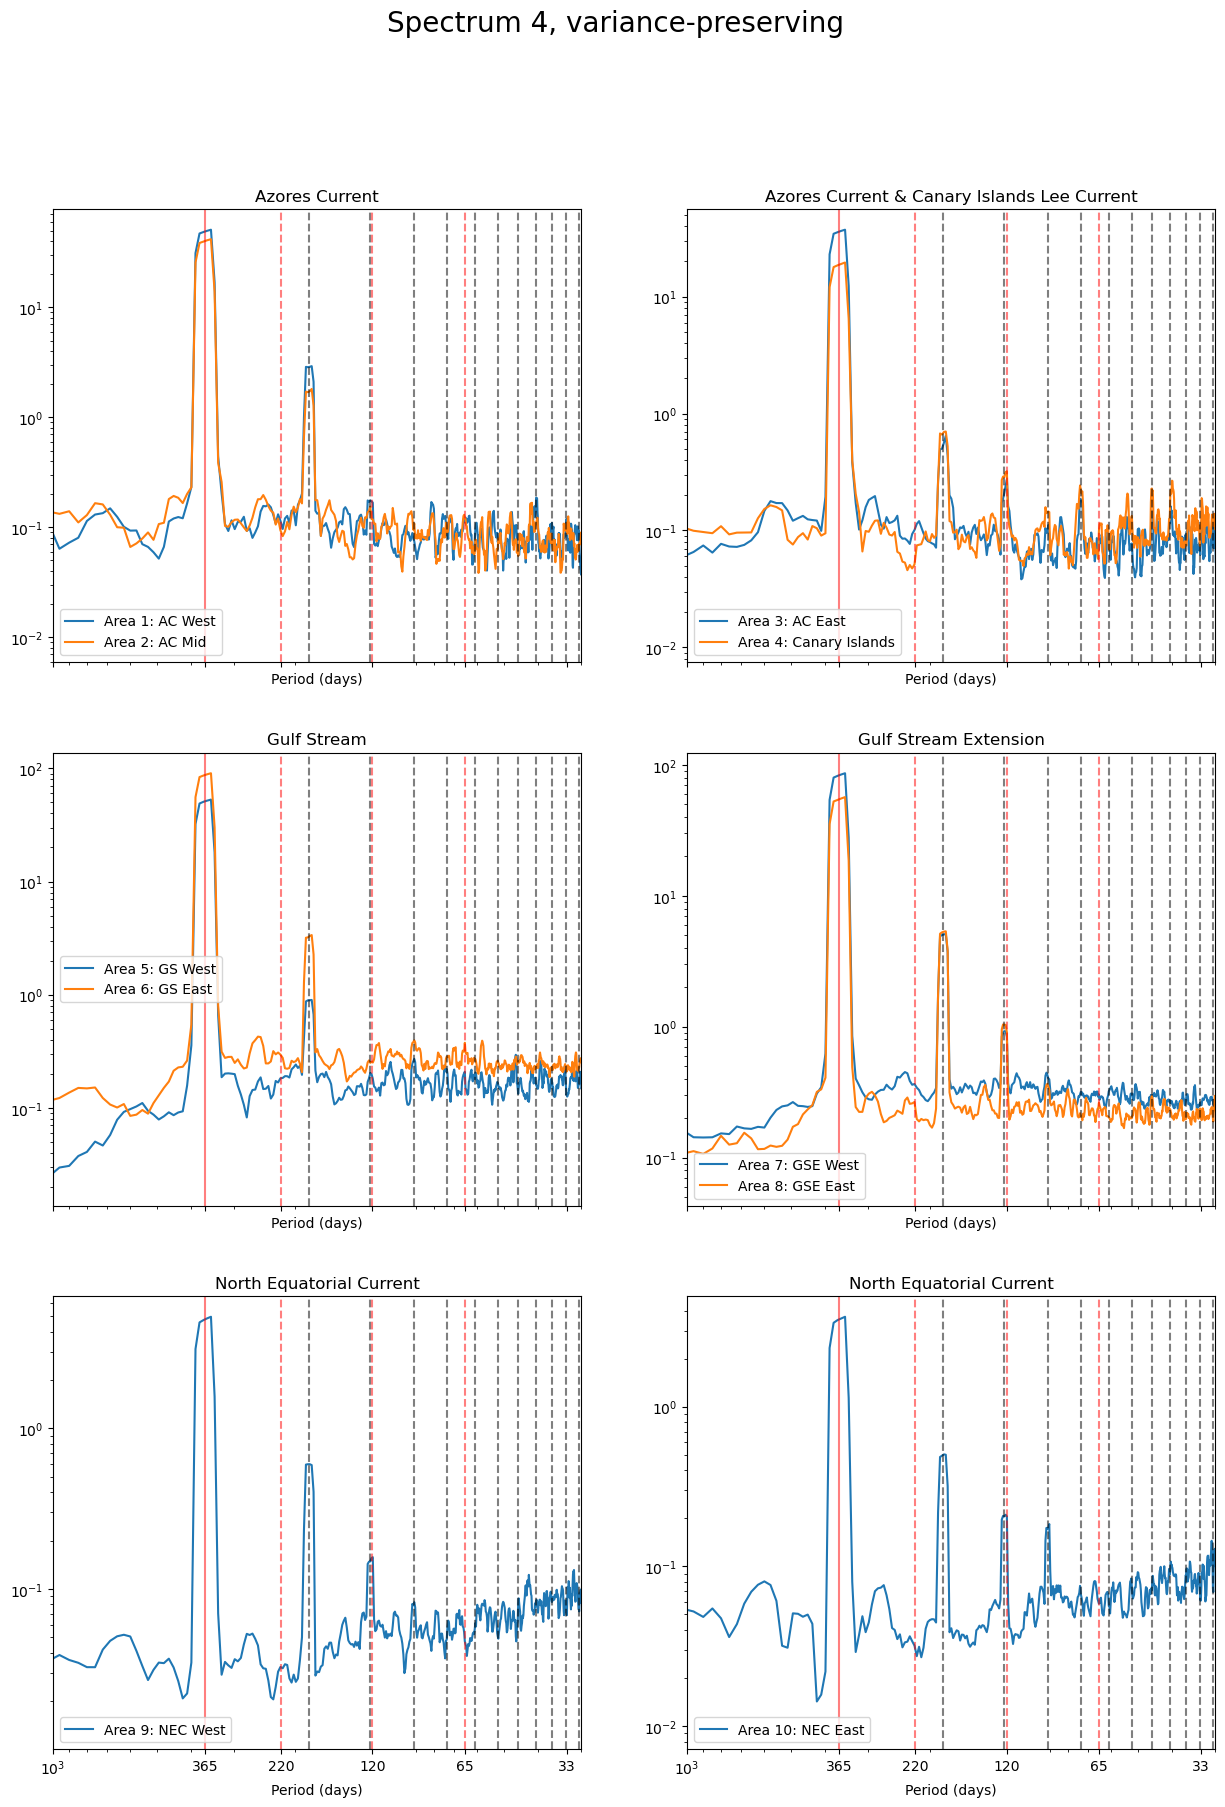

In [21]:
fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(1000, 30)
fig.suptitle('Spectrum 4, variance-preserving', fontsize=20)



ax[0, 0].set_title('Azores Current')
ax[0, 0].loglog((1/freqs1p)[::-1], media1p[::-1]*freqs1p[::-1])
ax[0, 0].loglog((1/freqs2p)[::-1], media2p[::-1]*freqs2p[::-1])
ax[0, 0].legend(('Area 1: AC West', 'Area 2: AC Mid'))

ax[0, 1].set_title('Azores Current & Canary Islands Lee Current')
ax[0, 1].loglog((1/freqs3p)[::-1], media3p[::-1]*freqs3p[::-1])
ax[0, 1].loglog((1/freqs4p)[::-1], media4p[::-1]*freqs4p[::-1])
ax[0, 1].legend(('Area 3: AC East', 'Area 4: Canary Islands'))

ax[1, 0].set_title('Gulf Stream')
ax[1, 0].loglog((1/freqs5p)[::-1], media5p[::-1]*freqs5p[::-1])
ax[1, 0].loglog((1/freqs6p)[::-1], media6p[::-1]*freqs6p[::-1])
ax[1, 0].legend(('Area 5: GS West', 'Area 6: GS East'))

ax[1, 1].set_title('Gulf Stream Extension')
ax[1, 1].loglog((1/freqs7p)[::-1], media7p[::-1]*freqs7p[::-1])
ax[1, 1].loglog((1/freqs8p)[::-1], media8p[::-1]*freqs8p[::-1])
ax[1, 1].legend(('Area 7: GSE West', 'Area 8: GSE East'))

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].loglog((1/freqs9p)[::-1], media9p[::-1]*freqs9p[::-1])
ax[2, 0].legend(('Area 9: NEC West',))

ax[2, 1].set_title('North Equatorial Current')
ax[2, 1].loglog((1/freqs10p)[::-1], media10p[::-1]*freqs10p[::-1])
ax[2, 1].legend(('Area 10: NEC East',))

for ax in ax.flat:
  ax.axvline(365, ls='-', color='r', alpha=0.5)
  ax.axvline(182.5, ls='--', color='k', alpha=0.5)
  ax.axvline(121.7, ls='--', color='k', alpha=0.5)
  ax.axvline(91.25, ls='--', color='k', alpha=0.5)
  ax.axvline(73, ls='--', color='k', alpha=0.5)
  ax.axvline(60.83, ls='--', color='k', alpha=0.5)
  ax.axvline(52.15, ls='--', color='k', alpha=0.5)
  ax.axvline(45.625, ls='--', color='k', alpha=0.5)
  ax.axvline(40.55, ls='--', color='k', alpha=0.5)
  ax.axvline(36.5, ls='--', color='k', alpha=0.5)
  ax.axvline(33.18, ls='--', color='k', alpha=0.5)
  ax.axvline(30.41, ls='--', color='k', alpha=0.5)
  ax.axvline(28.07, ls='--', color='k', alpha=0.5)
  ax.axvline(220, ls='--', color='r', alpha=0.5)
  ax.axvline(120, ls='--', color='r', alpha=0.5)
  ax.axvline(65, ls='--', color='r', alpha=0.5)
  ax.set(xlabel='Period (days)')

plt.xticks([33, 65, 120, 220, 365, 1000], ['33', '65', '120', '220', '365', '$10^3$'])

plt.show()

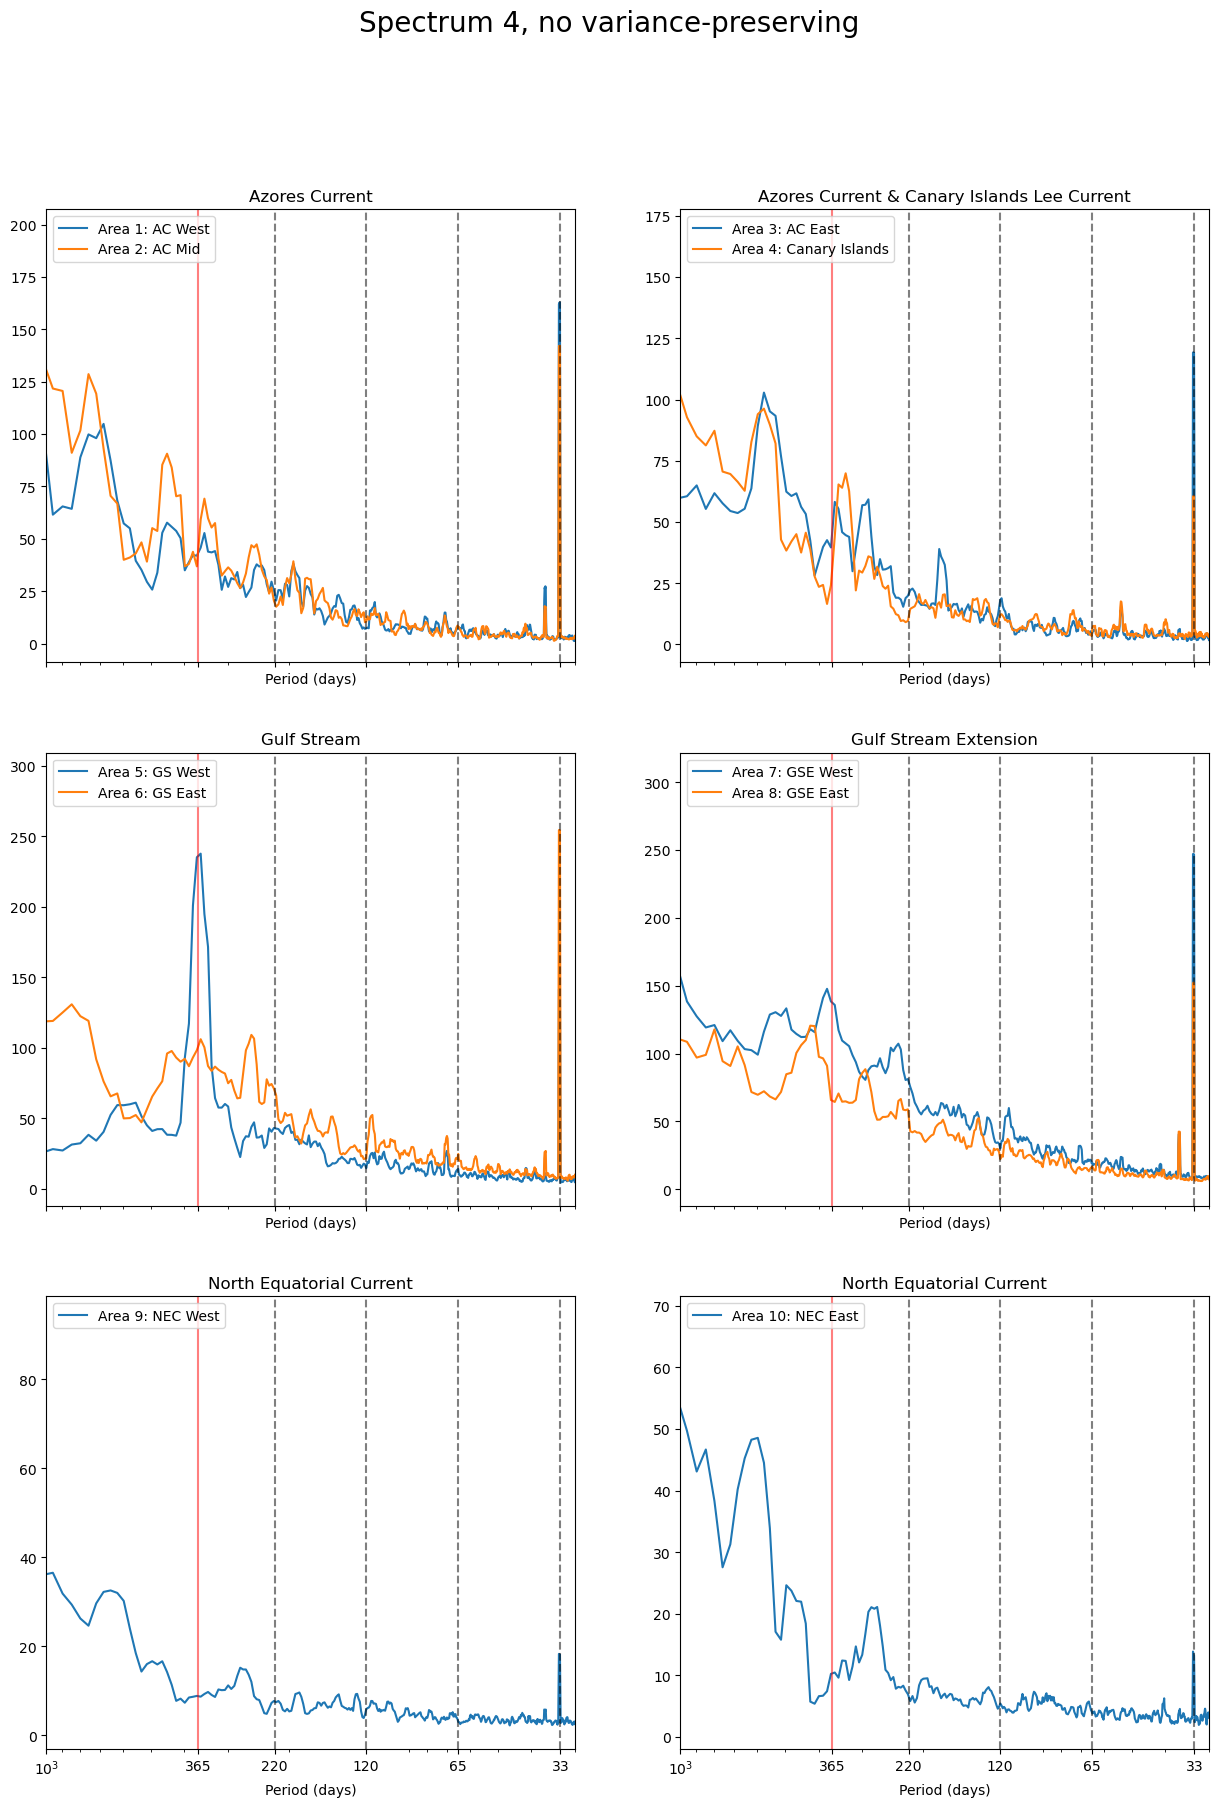

In [22]:
fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(1000, 30)
fig.suptitle('Spectrum 4, no variance-preserving', fontsize=20)


ax[0, 0].set_title('Azores Current')
ax[0, 0].semilogx((1/freqs1)[::-1], media1[::-1])
ax[0, 0].semilogx((1/freqs2)[::-1], media2[::-1])

ax[0, 1].set_title('Azores Current & Canary Islands Lee Current')
ax[0, 1].semilogx((1/freqs3)[::-1], media3[::-1])
ax[0, 1].semilogx((1/freqs4)[::-1], media4[::-1])

ax[1, 0].set_title('Gulf Stream')
ax[1, 0].semilogx((1/freqs5)[::-1], media5[::-1])
ax[1, 0].semilogx((1/freqs6)[::-1], media6[::-1])

ax[1, 1].set_title('Gulf Stream Extension')
ax[1, 1].semilogx((1/freqs7)[::-1], media7[::-1])
ax[1, 1].semilogx((1/freqs8)[::-1], media8[::-1])

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].semilogx((1/freqs9)[::-1], media9[::-1])

ax[2, 1].set_title('North Equatorial Current')
ax[2, 1].semilogx((1/freqs10)[::-1], media10[::-1])

ax[0, 0].legend(('Area 1: AC West', 'Area 2: AC Mid'))
ax[0, 1].legend(('Area 3: AC East', 'Area 4: Canary Islands'))
ax[1, 0].legend(('Area 5: GS West', 'Area 6: GS East'))
ax[1, 1].legend(('Area 7: GSE West', 'Area 8: GSE East'))
ax[2, 0].legend(('Area 9: NEC West', ))
ax[2, 1].legend(('Area 10: NEC East', ))


for ax in ax.flat:
    ax.axvline(365, ls='-', color='r', alpha=0.5)
    ax.axvline(220, ls='--', color='k', alpha=0.5)
    ax.axvline(120, ls='--', color='k', alpha=0.5)
    ax.axvline(65, ls='--', color='k', alpha=0.5)
    ax.axvline(33, ls='--', color='k', alpha=0.5)
    ax.set(xlabel='Period (days)')

plt.xticks([33, 65, 120, 220, 365, 1000], ['33', '65', '120', '220', '365', '$10^3$'])

plt.show()

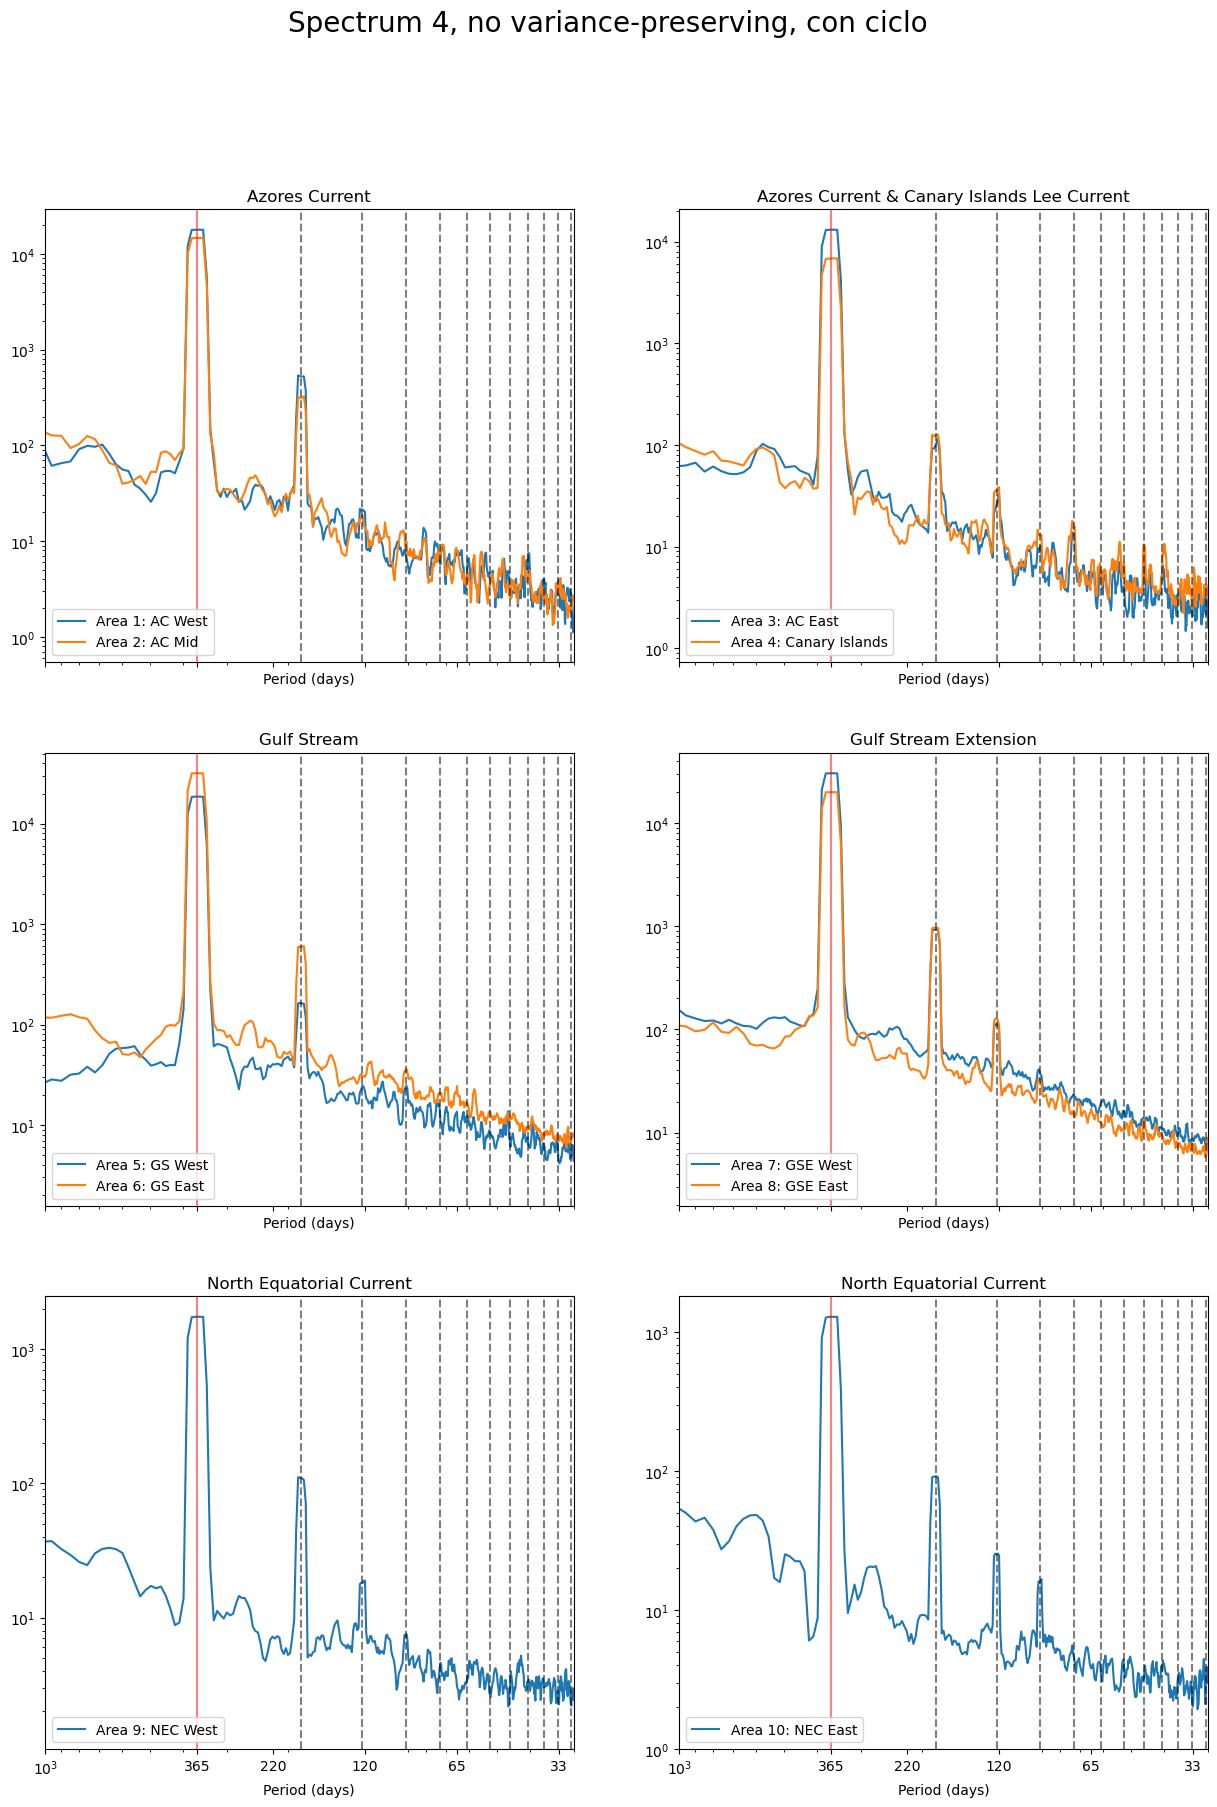

In [23]:
fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(1000, 30)
fig.suptitle('Spectrum 4, no variance-preserving, con ciclo', fontsize=20)


ax[0, 0].set_title('Azores Current')
ax[0, 0].loglog((1/freqs1p)[::-1], media1p[::-1])
ax[0, 0].loglog((1/freqs2p)[::-1], media2p[::-1])

ax[0, 1].set_title('Azores Current & Canary Islands Lee Current')
ax[0, 1].loglog((1/freqs3p)[::-1], media3p[::-1])
ax[0, 1].loglog((1/freqs4p)[::-1], media4p[::-1])

ax[1, 0].set_title('Gulf Stream')
ax[1, 0].loglog((1/freqs5p)[::-1], media5p[::-1])
ax[1, 0].loglog((1/freqs6p)[::-1], media6p[::-1])

ax[1, 1].set_title('Gulf Stream Extension')
ax[1, 1].loglog((1/freqs7p)[::-1], media7p[::-1])
ax[1, 1].loglog((1/freqs8p)[::-1], media8p[::-1])

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].loglog((1/freqs9p)[::-1], media9p[::-1])

ax[2, 1].set_title('North Equatorial Current')
ax[2, 1].loglog((1/freqs10p)[::-1], media10p[::-1])

ax[0, 0].legend(('Area 1: AC West', 'Area 2: AC Mid'))
ax[0, 1].legend(('Area 3: AC East', 'Area 4: Canary Islands'))
ax[1, 0].legend(('Area 5: GS West', 'Area 6: GS East'))
ax[1, 1].legend(('Area 7: GSE West', 'Area 8: GSE East'))
ax[2, 0].legend(('Area 9: NEC West', ))
ax[2, 1].legend(('Area 10: NEC East', ))


for ax in ax.flat:
  ax.axvline(365, ls='-', color='r', alpha=0.5)
  ax.axvline(182.5, ls='--', color='k', alpha=0.5)
  ax.axvline(121.7, ls='--', color='k', alpha=0.5)
  ax.axvline(91.25, ls='--', color='k', alpha=0.5)
  ax.axvline(73, ls='--', color='k', alpha=0.5)
  ax.axvline(60.83, ls='--', color='k', alpha=0.5)
  ax.axvline(52.15, ls='--', color='k', alpha=0.5)
  ax.axvline(45.625, ls='--', color='k', alpha=0.5)
  ax.axvline(40.55, ls='--', color='k', alpha=0.5)
  ax.axvline(36.5, ls='--', color='k', alpha=0.5)
  ax.axvline(33.18, ls='--', color='k', alpha=0.5)
  ax.axvline(30.41, ls='--', color='k', alpha=0.5)
  ax.axvline(28.07, ls='--', color='k', alpha=0.5)
  ax.set(xlabel='Period (days)')

plt.xticks([33, 65, 120, 220, 365, 1000], ['33', '65', '120', '220', '365', '$10^3$'])

plt.show()

In [24]:
data_clim = atl_dt - atl_dt_month

In [25]:
a1_clim = data_clim.sel(lat=a1_lat, lon=a1_lon)
a2_clim = data_clim.sel(lat=a2_lat, lon=a2_lon)
a3_clim = data_clim.sel(lat=a3_lat, lon=a3_lon)
a4_clim = data_clim.sel(lat=a4_lat, lon=a4_lon)
a5_clim = data_clim.sel(lat=a5_lat, lon=a5_lon)
a6_clim = data_clim.sel(lat=a6_lat, lon=a6_lon)
a7_clim = data_clim.sel(lat=a7_lat, lon=a7_lon)
a8_clim = data_clim.sel(lat=a8_lat, lon=a8_lon)
a9_clim = data_clim.sel(lat=a9_lat, lon=a9_lon)
a10_clim = data_clim.sel(lat=a10_lat, lon=a10_lon)

In [26]:
freqs1_clim, ps1_clim, psd1_clim = spectrum4(a1_clim.values, dt=7)
freqs2_clim, ps2_clim, psd2_clim = spectrum4(a2_clim.values, dt=7)
freqs3_clim, ps3_clim, psd3_clim = spectrum4(a3_clim.values, dt=7)
freqs4_clim, ps4_clim, psd4_clim = spectrum4(a4_clim.values, dt=7)
freqs5_clim, ps5_clim, psd5_clim = spectrum4(a5_clim.values, dt=7)
freqs6_clim, ps6_clim, psd6_clim = spectrum4(a6_clim.values, dt=7)
freqs7_clim, ps7_clim, psd7_clim = spectrum4(a7_clim.values, dt=7)
freqs8_clim, ps8_clim, psd8_clim = spectrum4(a8_clim.values, dt=7)
freqs9_clim, ps9_clim, psd9_clim = spectrum4(a9_clim.values, dt=7)
freqs10_clim, ps10_clim, psd10_clim = spectrum4(a10_clim.values, dt=7)

In [27]:
media1_clim = np.nanmean(np.nanmean(psd1_clim, axis=1), axis=1)
media2_clim = np.nanmean(np.nanmean(psd2_clim, axis=1), axis=1)
media3_clim = np.nanmean(np.nanmean(psd3_clim, axis=1), axis=1)
media4_clim = np.nanmean(np.nanmean(psd4_clim, axis=1), axis=1)
media5_clim = np.nanmean(np.nanmean(psd5_clim, axis=1), axis=1)
media6_clim = np.nanmean(np.nanmean(psd6_clim, axis=1), axis=1)
media7_clim = np.nanmean(np.nanmean(psd7_clim, axis=1), axis=1)
media8_clim = np.nanmean(np.nanmean(psd8_clim, axis=1), axis=1)
media9_clim = np.nanmean(np.nanmean(psd9_clim, axis=1), axis=1)
media10_clim = np.nanmean(np.nanmean(psd10_clim, axis=1), axis=1)

In [28]:
#Integral del PSD entre 65 y 220 sobre todo el Atlántico.

inte = np.zeros([psd_t.shape[1],psd_t.shape[2]])

for i in range(psd_t.shape[1]):
  for j in range(psd_t.shape[2]):
    inte[i,j] = np.trapz(psd_t[65:220,i,j], freqs_t[65:220])

In [29]:
#Integral del PSD entre 220 y 300 sobre todo el Atlántico.

intep = np.zeros([psd_t.shape[1],psd_t.shape[2]])

for i in range(psd_t.shape[1]):
  for j in range(psd_t.shape[2]):
    intep[i,j] = np.trapz(psd_t[46:65,i,j], freqs_t[46:65])

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


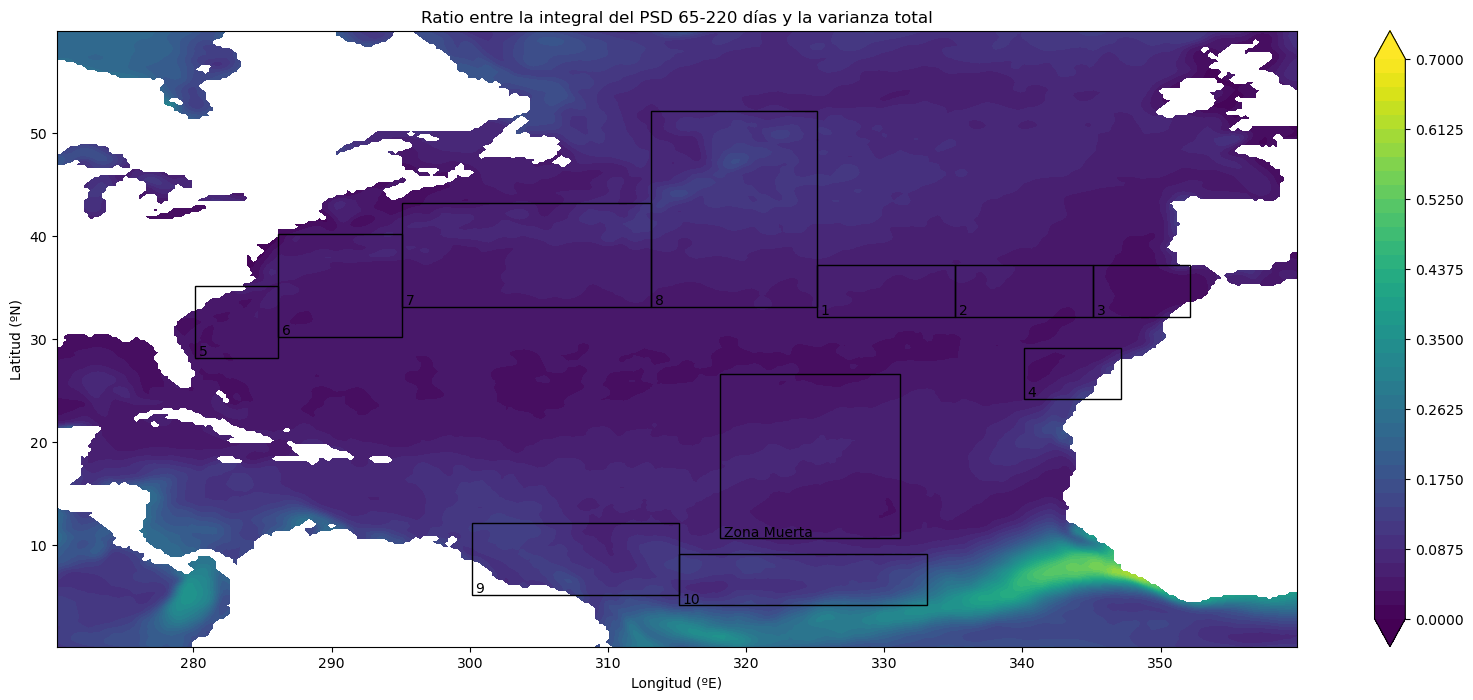

In [30]:
#Representación del ratio 65-220 días y varianza total.

fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0, 0.7, 41)
B = ax.contourf(atl_dt_month.lon, atl_dt_month.lat, inte / atl_dt.var(dim='time'), 
                levels=levels, extend='both')
fig.colorbar(B)

#ax.contourf(atl_dt_month.longitude, atl_dt_month.latitude, atl_dt_month.std(dim='time'), levels=[0.0599*100, 0.06*100], colors='red')

ax.add_patch(mtp.Rectangle((a1_lon[0],a1_lat[0]), len(a1_lon)*0.25, len(a1_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a1_lon[1],a1_lat[1], '1')
ax.add_patch(mtp.Rectangle((a2_lon[0],a2_lat[0]), len(a2_lon)*0.25, len(a2_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a2_lon[1],a2_lat[1], '2')
ax.add_patch(mtp.Rectangle((a3_lon[0],a3_lat[0]), len(a3_lon)*0.25, len(a3_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a3_lon[1],a3_lat[1], '3')
ax.add_patch(mtp.Rectangle((a4_lon[0],a4_lat[0]), len(a4_lon)*0.25, len(a4_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a4_lon[1],a4_lat[1], '4')
ax.add_patch(mtp.Rectangle((a5_lon[0],a5_lat[0]), len(a5_lon)*0.25, len(a5_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a5_lon[1],a5_lat[1], '5')
ax.add_patch(mtp.Rectangle((a6_lon[0],a6_lat[0]), len(a6_lon)*0.25, len(a6_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a6_lon[1],a6_lat[1], '6')
ax.add_patch(mtp.Rectangle((a7_lon[0],a7_lat[0]), len(a7_lon)*0.25, len(a7_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a7_lon[1],a7_lat[1], '7')
ax.add_patch(mtp.Rectangle((a8_lon[0],a8_lat[0]), len(a8_lon)*0.25, len(a8_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a8_lon[1],a8_lat[1], '8')
ax.add_patch(mtp.Rectangle((a9_lon[0],a9_lat[0]), len(a9_lon)*0.25, len(a9_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a9_lon[1],a9_lat[1], '9')
ax.add_patch(mtp.Rectangle((a10_lon[0],a10_lat[0]), len(a10_lon)*0.25, len(a10_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a10_lon[1],a10_lat[1], '10')
ax.add_patch(mtp.Rectangle((ad_lon[0],ad_lat[0]), len(ad_lon)*0.25, len(ad_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(ad_lon[1],ad_lat[1], 'Zona Muerta')

ax.set_title('Ratio entre la integral del PSD 65-220 días y la varianza total')
ax.set_xlabel('Longitud (ºE)')
ax.set_ylabel('Latitud (ºN)')


plt.show()

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


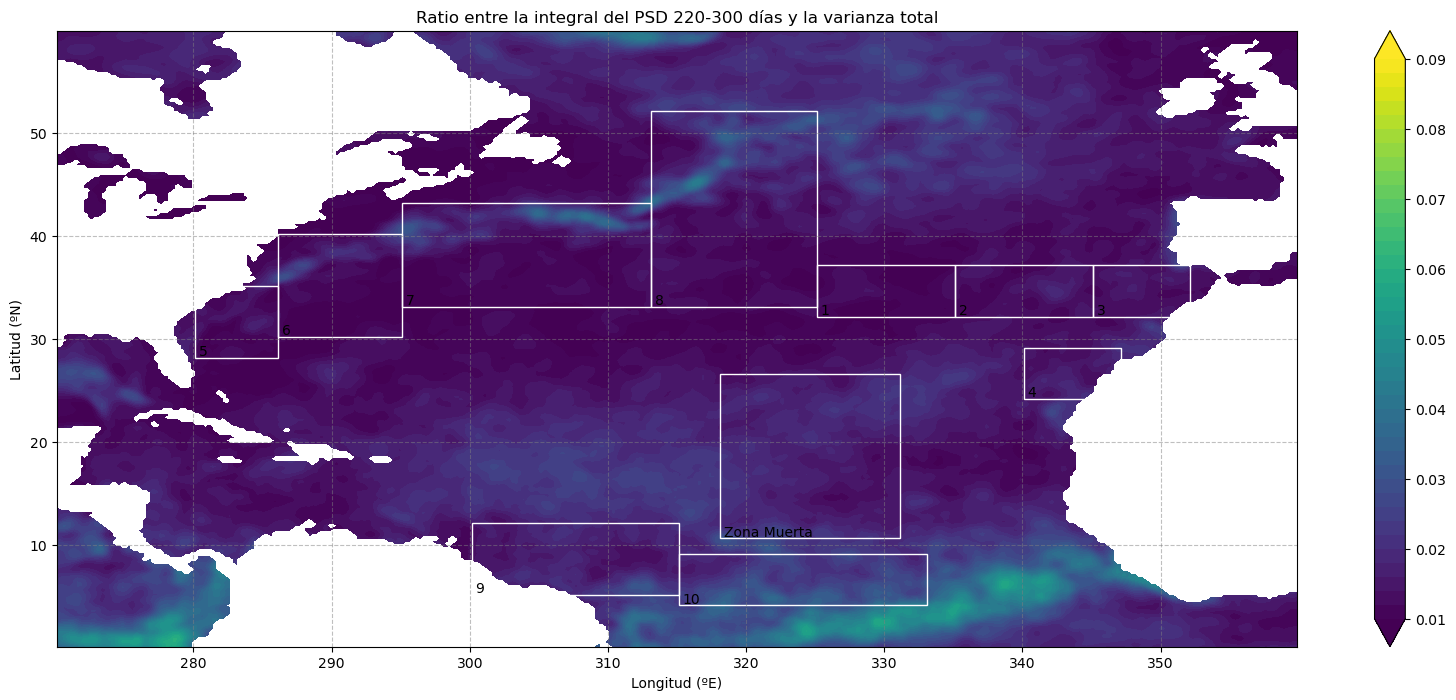

In [31]:
#Representación del ratio 220-300 días y varianza total.

fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0.01, 0.09, 41)
B = ax.contourf(atl_dt_month.lon, atl_dt_month.lat, intep / atl_dt.var(dim='time'), 
                levels=levels, extend='both')
fig.colorbar(B)

#ax.contourf(atl_dt_month.longitude, atl_dt_month.latitude, atl_dt_month.std(dim='time'), levels=[0.0599*100, 0.06*100], colors='red')

ax.add_patch(mtp.Rectangle((a1_lon[0],a1_lat[0]), len(a1_lon)*0.25, len(a1_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a1_lon[1],a1_lat[1], '1')
ax.add_patch(mtp.Rectangle((a2_lon[0],a2_lat[0]), len(a2_lon)*0.25, len(a2_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a2_lon[1],a2_lat[1], '2')
ax.add_patch(mtp.Rectangle((a3_lon[0],a3_lat[0]), len(a3_lon)*0.25, len(a3_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a3_lon[1],a3_lat[1], '3')
ax.add_patch(mtp.Rectangle((a4_lon[0],a4_lat[0]), len(a4_lon)*0.25, len(a4_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a4_lon[1],a4_lat[1], '4')
ax.add_patch(mtp.Rectangle((a5_lon[0],a5_lat[0]), len(a5_lon)*0.25, len(a5_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a5_lon[1],a5_lat[1], '5')
ax.add_patch(mtp.Rectangle((a6_lon[0],a6_lat[0]), len(a6_lon)*0.25, len(a6_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a6_lon[1],a6_lat[1], '6')
ax.add_patch(mtp.Rectangle((a7_lon[0],a7_lat[0]), len(a7_lon)*0.25, len(a7_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a7_lon[1],a7_lat[1], '7')
ax.add_patch(mtp.Rectangle((a8_lon[0],a8_lat[0]), len(a8_lon)*0.25, len(a8_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a8_lon[1],a8_lat[1], '8')
ax.add_patch(mtp.Rectangle((a9_lon[0],a9_lat[0]), len(a9_lon)*0.25, len(a9_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a9_lon[1],a9_lat[1], '9')
ax.add_patch(mtp.Rectangle((a10_lon[0],a10_lat[0]), len(a10_lon)*0.25, len(a10_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a10_lon[1],a10_lat[1], '10')
ax.add_patch(mtp.Rectangle((ad_lon[0],ad_lat[0]), len(ad_lon)*0.25, len(ad_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(ad_lon[1],ad_lat[1], 'Zona Muerta')

ax.set_title('Ratio entre la integral del PSD 220-300 días y la varianza total')
ax.set_xlabel('Longitud (ºE)')
ax.set_ylabel('Latitud (ºN)')

ax.xaxis.grid(True, zorder=0, color='grey', linestyle='--', alpha=0.5)
ax.yaxis.grid(True, zorder=0, color='grey', linestyle='--', alpha=0.5)

plt.show()